In [1]:
import scipy.io
import constants
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

## Convert annotations in `mat` file format to csv file

In [2]:
mat = scipy.io.loadmat(os.path.join(constants.dataset_folder, constants.annotations_file))
mat = {k:v for k, v in mat.items() if k[0] != '_'}

In [3]:
all_annotations = mat['annotations'][0]
all_class_names = mat['class_names'][0]

In [4]:
def prepare_annotations(annotations, class_names):
    arr_annotations = []
    for anno in annotations:
        img_path = anno[0][0]
        bbox_x1 = anno[1][0][0]
        bbox_x2 = anno[2][0][0]
        bbox_y1 = anno[3][0][0]
        bbox_y2 = anno[4][0][0]
        indx_class_name = anno[5][0][0]
        train_test = anno[6][0][0]
        string_class_name = class_names[indx_class_name-1][0]
        arr_annotations.append({'img_path': img_path,
                                'bbox_x1': bbox_x1,
                                'bbox_x2': bbox_x2,
                                'bbox_y1': bbox_y1,
                                'bbox_y2': bbox_y2,
                                'indx_class_name': indx_class_name,
                                'string_class_name': string_class_name,
                                'train_test': train_test})
  
    df = pd.DataFrame(arr_annotations, columns=['img_path', 'bbox_x1', 'bbox_x2', 'bbox_y1', 'bbox_y2',
                                        'indx_class_name', 'string_class_name', 'train_test'])
    return df

In [5]:
df = prepare_annotations(all_annotations, all_class_names)
df.to_csv(os.path.join(constants.dataset_folder, 'train_test_labels.csv'), index=False)

## Display some random images from the dataset

In [ ]:
def display_image(image_pth):
    im = Image.open(image_pth)
    plt.imshow(np.asarray(im))
    plt.show()

car_ims/002438.jpg BMW 3 Series Wagon 2012


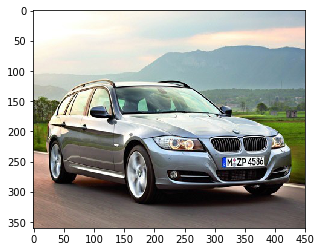

car_ims/013508.jpg Mercedes-Benz S-Class Sedan 2012


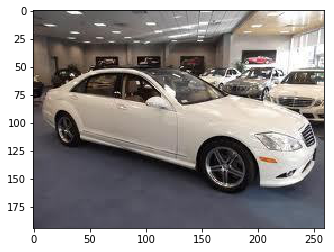

car_ims/004105.jpg Cadillac CTS-V Sedan 2012


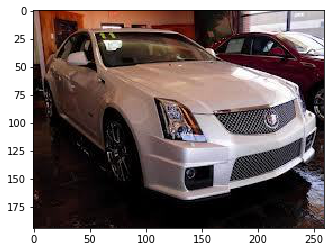

car_ims/010137.jpg Geo Metro Convertible 1993


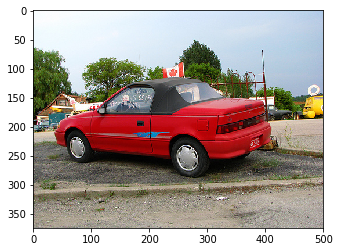

car_ims/006097.jpg Chevrolet Silverado 1500 Regular Cab 2012


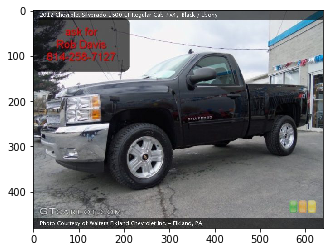

In [234]:
for i in np.arange(5):
    indx = np.random.randint(len(df))
    row = df.iloc[indx]
    image_path = row['img_path']
    image_class_name = row['string_class_name']
    print(image_path, image_class_name)
    display_image(os.path.join(constants.dataset_folder, image_path))

## Make training and testing CSV files

Combination of training and testing data can be downloaded from this [url](http://imagenet.stanford.edu/internal/car196/car_ims.tgz). The annotation file has an extra column which has either 0 or 1. That column is extracted as `train_test` column and 0 represents training data and 1 represents testing data.

In [ ]:
def clean_name(row):
    return row['tags'].replace(' ', '_')

In [8]:
df_train = df[df['train_test'] == 0][['img_path', 'string_class_name']]\
df_train.rename(columns={'img_path':'image_name', 'string_class_name':'tags'}, inplace=True)
df_train['tags'] = df_train.apply(clean_name, axis=1)

In [9]:
df_train.to_csv(os.path.join(constants.dataset_folder,'train_cars.csv'), index=False)

In [10]:
df_test = df[df['train_test'] == 1][['img_path', 'string_class_name']]
df_test.rename(columns={'img_path':'image_name', 'string_class_name':'tags'}, inplace=True)
df_test['tags'] = df_test.apply(clean_name, axis=1)

In [11]:
df_test.to_csv(os.path.join(constants.dataset_folder,'test_cars.csv'), index=False)

## Label Splitting

This is an important consideration made for this project. The labels of each image contains both the vehicle's manufacturer (e.g. Tesla, Aston Martin, etc.) as well as the vehicle's name (e.g. Model S 2012, V8 Vantage 2012, etc.). While doing initial data exploration, I trained a deep neural netowrk with original labels. The model has subpar performance, yielding very bad precision and recall. Therefore, I split the labels to vehicle's manfacturer and vehicle's name. Trainign the model to learn the manufacturer and name separately produces better results.

In [235]:
arr_two_words_brands = ['AM_General', 'Aston_Martin', 'Land_Rover']

In [236]:
def get_brand(row):
    tag = row['tags']
    brand_name = tag.split('_')[0]
    two_words_brand_name = '_'.join(tag.split('_')[:2])
    if two_words_brand_name in arr_two_words_brands:
        brand_name = two_words_brand_name
    return brand_name

In [237]:
def get_model(row):
    tag = row['tags']
    brand_name = tag.split('_')[0]
    model_name = '_'.join(tag.split('_')[1:])
    two_words_brand_name = '_'.join(tag.split('_')[:2])
    if two_words_brand_name in arr_two_words_brands:
        brand_name = two_words_brand_name
        model_name = '_'.join(tag.split('_')[2:])
    return model_name

In [238]:
df_train['brand_name'] = df_train.apply(get_brand, axis=1)
df_train['model_name'] = df_train.apply(get_model, axis=1)

In [243]:
print("Unique manufacturers in the dataset: {}".format(len(df_train['brand_name'].unique())))
print("Unique model names in the dataset: {}".format(len(df_train['model_name'].unique())))

Unique manufacturers in the dataset: 49
Unique model names in the dataset: 196


In [77]:
df_train[['image_name', 'brand_name']].to_csv('datasets/train_brand_name.csv', index=False)

## Data Distribution

Now, I want to check the data distribution in the training dataset. During the initial data exploration stage, I trained a deep neural network with the original training data. When I did the qualitative check, I realized that there were some vehicles where the model was doing a very bad job. On closer inspection, I realized that those vehicles are severly under-represented in the dataset.

Therefore, I plotted a histogram of vehicle manufacturers in the dataset, with the intention of understanding the manufacturer distribution in the dataset.

In [246]:
brands = np.unique(df_train['brand_name'].values, return_counts=True)[0]
counts = np.unique(df_train['brand_name'].values, return_counts=True)[1]
dict_counts = dict(zip(brands,counts))

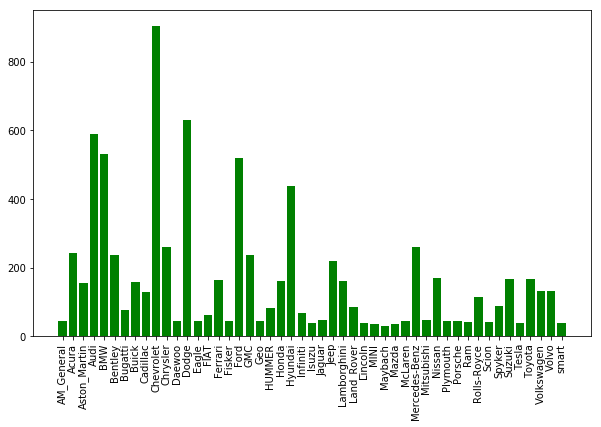

In [247]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation='vertical')
plt.bar(dict_counts.keys(), dict_counts.values(), color='g')
plt.show()

As it can be seen, the data distribution is very unbalanced. Now, my next step is to synthetically balance the vehicle manufacturers in the data by generating synthetic vehicle images from original images of under-represented vehicle manufacturers.

## Syntheic Data Generation

At this point, there are two things I can do.

- Get more real data from the Internet.
- Use the images which I already have from the dataset and generate variants of the image using several affine transformations, color changes, lighting changes, contrast changes, etc.

I decided to choose the path where I use the image from the dataset. Usually in the real world setting, getting more data may not be as simple as finding more resources on the Internet and the decision to synthetically generate data is rooted in that line of thought.

In [135]:
import imgaug.augmenters as iaa
import cv2

Generate data using the combination of following transformations (in random order):
- Cropping and padding
- Horizontal flipping
- Gaussian Blurring
- Constrast Normalization
- Scaling, Translating, Rotating and Shearing
- Graysclaing the image and overlapping with original image with certain transparency values
- Inverting color channels

In [174]:
seq = iaa.Sequential([
    iaa.CropAndPad(percent=(-0.10, 0.10)),
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.ContrastNormalization((0.70, 1.6)),
    iaa.Affine(
        scale={"x": (0.9, 1.4), "y": (0.9, 1.4)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)},
        rotate=(-10, 10),
        shear=(-4, 4)
    ),
    iaa.Sometimes(0.8,
                  iaa.Grayscale(alpha=(0.0, 1.0))
    ),
    iaa.Sometimes(0.3,
                  iaa.Invert(0.3)
    )
], random_order=True)

Generate new images for under-represented manufacturers to match up with the manufacture which has the most images in the dataset.

In [ ]:
max_count = max(dict_counts.values())
arr_new_images = []
for key in dict_counts.keys():
    car_df = df_train[df_train['brand_name']== key]
    df_len = len(car_df)
    if df_len < max_count:
        for i in range(max_count-df_len):
            rand_indx = np.random.randint(df_len)
            image_path = car_df.iloc[rand_indx]['image_name']
            tag = car_df.iloc[rand_indx]['tags']
            car_img = os.path.join('datasets', image_path)
            bgr_img = cv2.imread(car_img)
            rgb_image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
            rgb_image = np.expand_dims(rgb_image, axis=0)
            aug_image = seq.augment_images(rgb_image)
            new_filename = image_path.split('.')[0] + '_{}.jpg'.format(i)
            aug_bgr_image = cv2.cvtColor(aug_image[0], cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(constants.dataset_folder, new_filename), aug_bgr_image)
            arr_new_images.append({'image_name': new_filename, 'tags': tag})

In [188]:
df_aug = pd.DataFrame(arr_new_images)
df_aug['brand_name'] = df_aug.apply(get_brand, axis=1)
df_aug['model_name'] = df_aug.apply(get_model, axis=1)

## Combine original training dataset with generated dataset

In [204]:
df_combined = pd.concat([df_aug, df_train]).reset_index(drop=True)

Now let's check back the vehicle manufacturer distribution

In [248]:
combined_brands = np.unique(df_combined['brand_name'].values, return_counts=True)[0]
combined_counts = np.unique(df_combined['brand_name'].values, return_counts=True)[1]
dict_counts_combined = dict(zip(combined_brands,combined_counts))

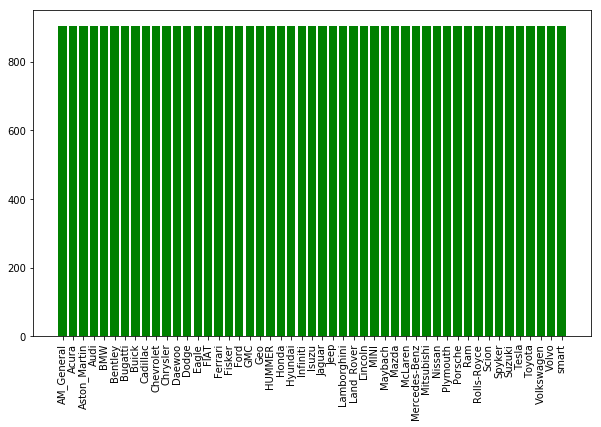

In [250]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation='vertical')
plt.bar(dict_counts_combined.keys(), dict_counts_combined.values(), color='g')
plt.show()

# Prepare data for training

In [ ]:
Now, label file is prepared

In [228]:
def get_brand_and_model_name(row):
    return "{} {}".format(row['brand_name'], row['model_name'])

In [229]:
df_combined['sep_tags'] = df_combined.apply(get_brand_and_model_name, axis=1)

In [231]:
df_combined[['image_name', 'sep_tags']].to_csv('datasets/train_tags_combined.csv', index=False)